In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue',
 'OD280/OD315 of diluted wines', 'Proline']

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
# This is the true test set. The split inside the sequential backward selection is for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

PCA is unsupervised and attempts to diagonally decompose the predictor variables into a variance explaining orthogonal subset before using the results to regress/classify. However, LDA (linear Discriminant Analysis) attemtps to isolate the subspace pertaining to class separability. They are both linear transformation techniques.

PCA tends to do better in image recognition tasks in certain cases despite bein unsupervised, especially if each class only consists of a small number of examples.

LDA assumes that each class is normally distributed across some feature space direction. It also assumes that the covariances for each class are i.i.d with respect to those feature space direction. LDA can work reasonably well even if those assumptions are slightly violated.

LDA procedure:

1) Standardize the feature dataset ($d$-dimensional for $d$ features).
2) Compute the mean $d$ dimensional feature vector for each class.
3) Construct the between-class (inter-class) scatter matrix $S_B$ and the within-class (intra-class) scatter matrix $S_W$.
4) Compute the eigensystem of $S_W^{-1}S_B$.
5) Rank eigenpairs by eigenvalues, and choose the $k$ largest eigenpairs.
6) Construct a $d \times k$ projector $W$ whose columns are the highest ranked eigenvectors.
7) Project feature examples onto this new subspace.

In [17]:
mean_vecs = {label: X_train_std[y_train==label].mean(axis=0) for label in sorted(np.unique(y_train))}
for label, vec in mean_vecs.items():
    print(f"Mean Vector {label}: {vec}")

Mean Vector 1: [ 0.95854072 -0.32201521  0.32191667 -0.76072471  0.43459496  0.85738095
  0.98093415 -0.4969177   0.42608046  0.2418433   0.42513874  0.71394348
  1.18789118]
Mean Vector 2: [-0.88291481 -0.30730723 -0.48748321  0.25359916 -0.32297732 -0.06318934
  0.04173645 -0.07842567  0.18495572 -0.85746433  0.45982254  0.29459356
 -0.70747471]
Mean Vector 3: [ 0.14683548  0.86569652  0.33865384  0.56090167 -0.05059175 -0.96948946
 -1.28197342  0.73620937 -0.80960862  0.9987164  -1.22490349 -1.33337457
 -0.40393341]


$$S_W = \sum_{i=1}^{c} \Sigma_i = \sum_{i=1}^{c} \frac{1}{|D_i|} S_i$$
$$S_i = \sum_{x \in D_i} (x - \mu_i)(x - \mu_i)^T$$

In [24]:
d = X.shape[1]
S_W = np.zeros((d, d))

for label in sorted(np.unique(y_train)):
    delta_vecs = (X_train_std[y_train == label] - mean_vecs[label]) # This subtracts the mean from each column
    # If we have n_i expamples in the class i, this creates an n_i x d matrix
    # To take the outer product and then average, we can simply to delta_vecs^T . delta_vecs
    class_scatter = delta_vecs.T.dot(delta_vecs)
    print(len(delta_vecs))
    S_W += class_scatter

41
50
33


In [26]:
# Since our classes have different numbers of samples, we can rescale each class scatter by dividing  
# S_W += class_scatter / len(delta_vecs)
# More simply put, the scaled intra class scatter is:
d = X.shape[1]
S_W = np.zeros((d, d))

for label in sorted(np.unique(y_train)):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter

$$S_B = \sum_{i=1}^c n_i (m_i - m)(m_i - m)^T$$
$$m = \mathrm{mean}(X)$$

$m$ is the mean of all examples, and $m_i$ is the mean of all examples labeled class $i$. $n_i = |D_i|$ is the number of examples in each class.

In [27]:
d = X.shape[1]
S_B = np.zeros((d, d))

examples_mean = np.mean(X_train_std, axis=0).reshape(d,1)

for label, vec in mean_vecs.items():
    n = X_train_std[y_train == label].shape[0]
    vec = vec.reshape(d, 1) # Column vectorize it
    S_B += n * (vec - examples_mean).dot((vec - examples_mean).T)

In [32]:
# Find eigensystem, and sort by |eigenvalue|
eigenvals, eigenvecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigenpairs = sorted([(np.abs(eigenvals[i]), eigenvecs[:,i]) for i in range(len(eigenvals))], key=lambda x: x[0], reverse=True)

for eigenval, _ in eigenpairs:
    print(eigenval)

418.4998828805773
204.57477642605855
5.684341886080802e-14
4.6219147815247015e-14
4.6219147815247015e-14
2.59679805334653e-14
2.59679805334653e-14
2.5799993248734788e-14
2.229860466918391e-14
8.021207974813663e-15
3.5362007156828917e-15
3.5362007156828917e-15
1.0102692023015694e-16


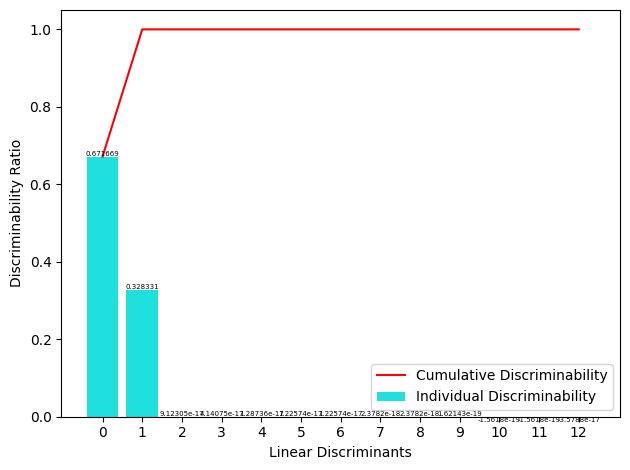

In [40]:
# Just like with explained variance fraction for PCA, we can compute discriminability for LDA
total_discrimination = sum(eigenvals.real)
discriminability = [(e / total_discrimination) for e in sorted(eigenvals.real, reverse=True)]

cumulative_discr = np.cumsum(discriminability)

ax1 = sns.barplot(discriminability, color='cyan', label='Individual Discriminability')
sns.lineplot(cumulative_discr, color='red', label='Cumulative Discriminability')
ax1.bar_label(ax1.containers[0], fontsize=5);
plt.xlabel('Linear Discriminants')
plt.ylabel('Discriminability Ratio')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [42]:
# Clearly, the first two are the only non-zero discriminants, up to computational artifacts
# Create a projector
n_discriminants = 2
W = np.hstack([eigenpairs[i][1][:, np.newaxis].real for i in range(n_discriminants)])
print(W)
print(W.shape)

[[-0.04877948 -0.38764046]
 [ 0.09489104 -0.22900115]
 [ 0.02094875 -0.40418652]
 [ 0.13679956  0.38632444]
 [-0.03145509 -0.04506765]
 [ 0.18028473 -0.09493979]
 [-0.83114386  0.18565084]
 [-0.08695994  0.01600516]
 [ 0.06703919  0.22979019]
 [ 0.25776529 -0.30881284]
 [-0.04927981  0.19435763]
 [-0.25391726  0.06322876]
 [-0.31586304 -0.49897025]]
(13, 2)


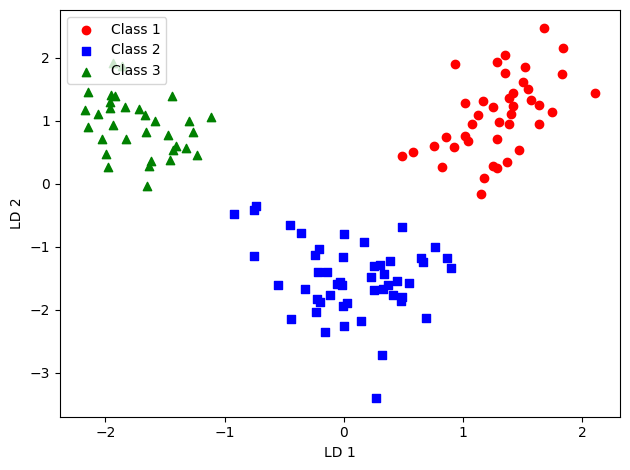

In [53]:
# Now we can project
X_train_lda = X_train_std.dot(W)
X_test_lda = X_test_std.dot(W)

colors = ['r', 'b', 'g']
markers = ['o', 's', '^']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        -X_train_lda[y_train == l, 0],
        -X_train_lda[y_train == l, 1],
        c=c, label=f'Class {l}', marker=m
    )

plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

Clearly, LD 1 is a really good discriminator of the 3 classes. LD 2 can only really discriminate against class 2 (1, 3 project onto the same LD 2 subspace).

In [50]:
# As usual, sklearn has this implemented for us

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression

lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)
X_test_lda = lda.transform(X_test_std)

lr = LogisticRegression(multi_class='ovr', random_state=42, solver='lbfgs').fit(X_train_lda, y_train)

print(f"Training score: {lr.score(X_train_lda, y_train) * 100:.2f}%.")
print(f"Test score: {lr.score(X_test_lda, y_test) * 100:.2f}%.")

Training score: 100.00%.
Test score: 98.15%.


c:\Users\sadit\miniconda3\envs\dataexercises\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


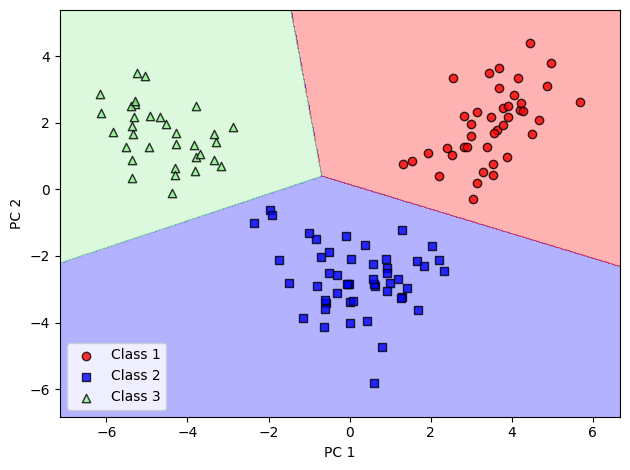

In [52]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')


plot_decision_regions(X_train_lda, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

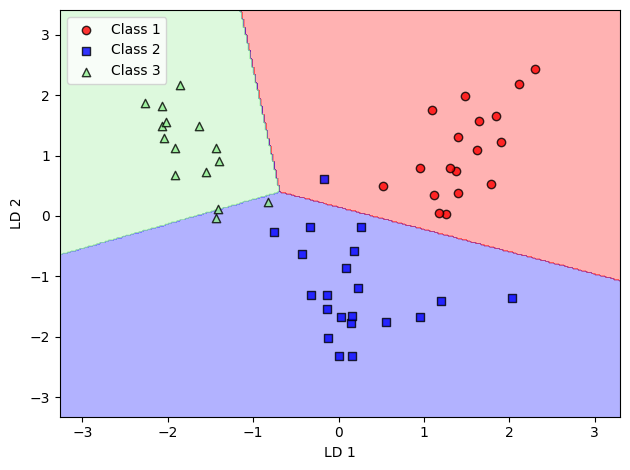

In [56]:
plot_decision_regions(-X_test_lda, y_test, classifier=lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='best')
plt.tight_layout()
plt.show()